## Setup

In [71]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [72]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
task = 'BlockTableBlue'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [74]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [75]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([162, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([162]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([162, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([162, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([162, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([162, 3, 256, 256]), device=cpu, dt

In [76]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
    #gt_frames=[[0, 2,8], [0,2, 8], [0, 2,8], [0,2, 8]],
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=10,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1,
    min_end_distance=20,
    #velocity_threshold=0.002,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [77]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-05 22:31:08.828 | INFO     |  Fitting AutoTPGMM
2025-08-05 22:31:08.829 | INFO     |  Segmenting trajectories


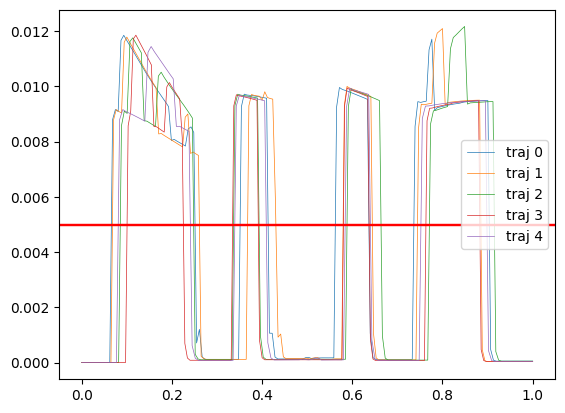

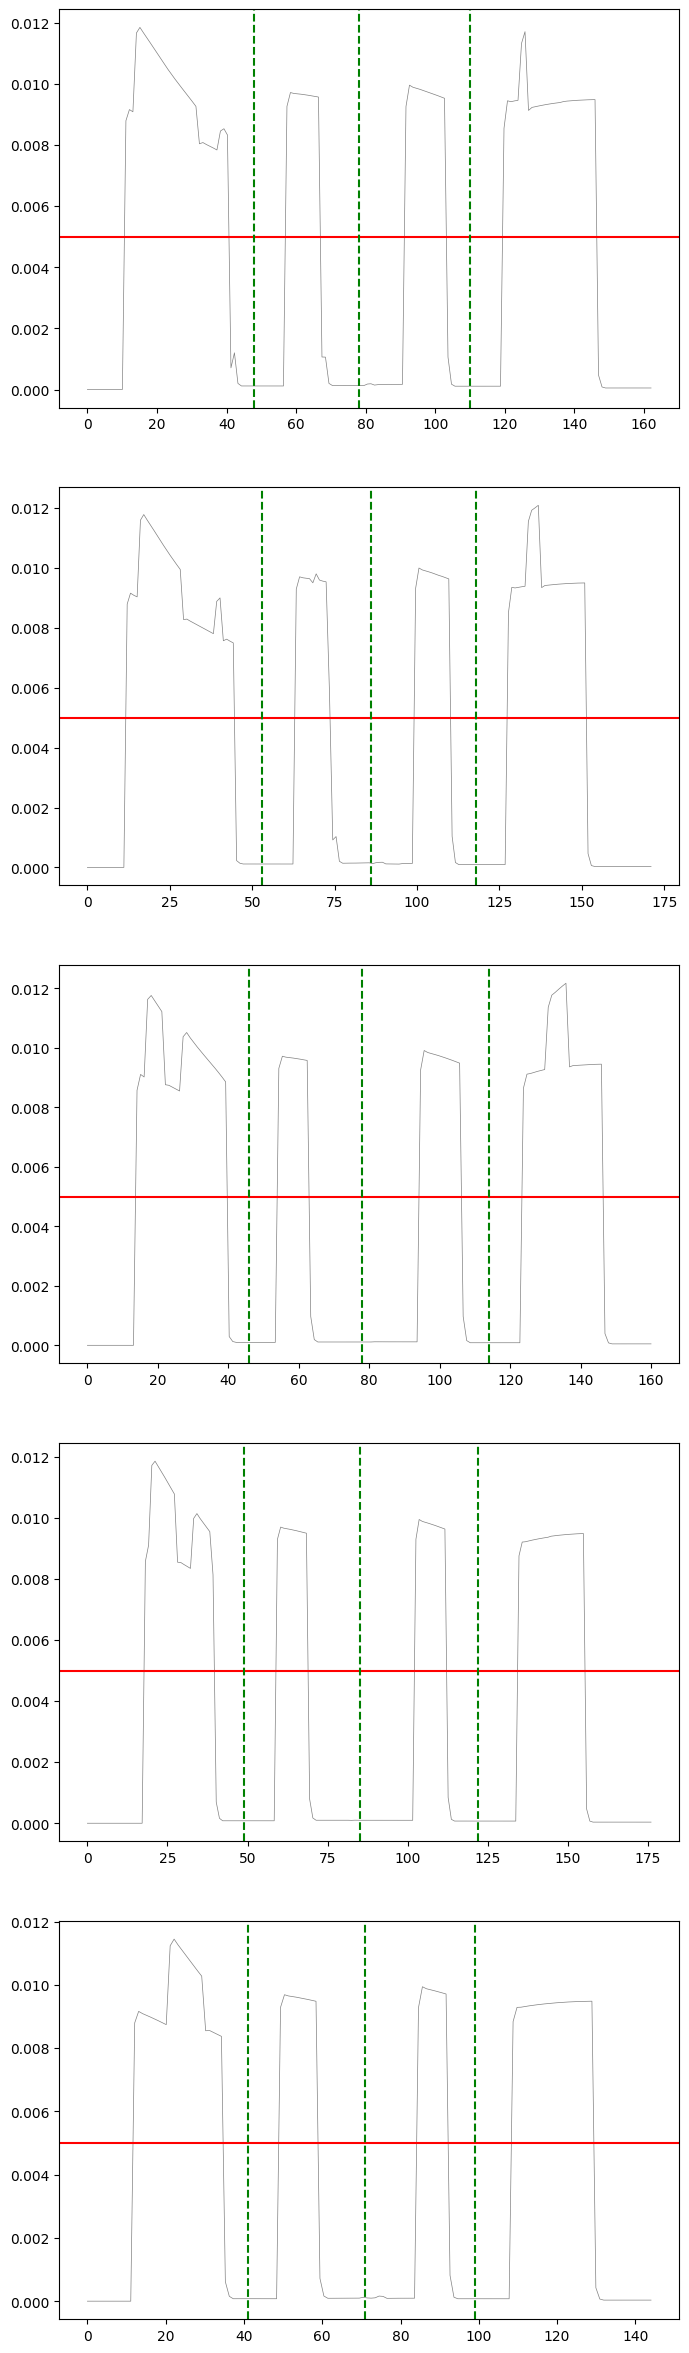

2025-08-05 22:31:09.775 | INFO     |  Creating segement of demos.
2025-08-05 22:31:09.796 | INFO     |  Subsampling to length 56 using strategy mean-length.
2025-08-05 22:31:09.797 | INFO     |  Creating segement of demos.
2025-08-05 22:31:09.804 | INFO     |  Subsampling to length 41 using strategy mean-length.
2025-08-05 22:31:09.806 | INFO     |  Creating segement of demos.
2025-08-05 22:31:09.815 | INFO     |  Subsampling to length 42 using strategy mean-length.
2025-08-05 22:31:09.816 | INFO     |  Creating segement of demos.
2025-08-05 22:31:09.824 | INFO     |  Subsampling to length 59 using strategy mean-length.
2025-08-05 22:31:09.825 | INFO     |  ... created 4 segments
2025-08-05 22:31:09.825 | INFO     |    Fitting candidate frame 1/10
2025-08-05 22:31:09.825 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:10.171 | INFO     |    Fitting candidate frame 2/10
2025-08-05 22:31:10.171 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:10.486 | INFO     |    Fitting candidate frame 3/10
2025-08-05 22:31:10.486 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:10.756 | INFO     |    Fitting candidate frame 4/10
2025-08-05 22:31:10.756 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:11.110 | INFO     |    Fitting candidate frame 5/10
2025-08-05 22:31:11.111 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:11.409 | INFO     |    Fitting candidate frame 6/10
2025-08-05 22:31:11.409 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:11.656 | INFO     |    Fitting candidate frame 7/10
2025-08-05 22:31:11.656 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:12.050 | INFO     |    Fitting candidate frame 8/10
2025-08-05 22:31:12.050 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:12.366 | INFO     |    Fitting candidate frame 9/10
2025-08-05 22:31:12.366 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:12.614 | INFO     |    Fitting candidate frame 10/10
2025-08-05 22:31:12.615 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:12.888 | INFO     |  Creating partial frame view of demos.
2025-08-05 22:31:12.890 | INFO     |    Fitting candidate frame 1/10
2025-08-05 22:31:12.890 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:13.155 | INFO     |    Fitting candidate frame 2/10
2025-08-05 22:31:13.156 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:13.407 | INFO     |    Fitting candidate frame 3/10
2025-08-05 22:31:13.408 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:13.622 | INFO     |    Fitting candidate frame 4/10
2025-08-05 22:31:13.622 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:13.833 | INFO     |    Fitting candidate frame 5/10
2025-08-05 22:31:13.833 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:14.031 | INFO     |    Fitting candidate frame 6/10
2025-08-05 22:31:14.032 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:14.314 | INFO     |    Fitting candidate frame 7/10
2025-08-05 22:31:14.314 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:14.575 | INFO     |    Fitting candidate frame 8/10
2025-08-05 22:31:14.576 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:14.839 | INFO     |    Fitting candidate frame 9/10
2025-08-05 22:31:14.839 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:15.069 | INFO     |    Fitting candidate frame 10/10
2025-08-05 22:31:15.070 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:15.267 | INFO     |  ee_init    score (rel):     -0 (0.223)
2025-08-05 22:31:15.268 | INFO     |  obj000     score (rel):     -0 (0.223)
2025-08-05 22:31:15.268 | INFO     |  obj001     score (rel):     -0 (0.223)
2025-08-05 22:31:15.268 | INFO     |  obj002     score (rel):     -0 (0.223)
2025-08-05 22:31:15.268 | INFO     |  obj003     score (rel):     -0 (0.223)
2025-08-05 22:31:15.268 | INFO     |  obj004     score (rel):     -0 (0.223)
2025-08-05 22:31:15.268 | INFO     |  obj005     score (rel):     -0 (0.223)
2025-08-05 22:31:15.268 | INFO     |  obj008     score (rel):     -0 (0.005)
2025-08-05 22:31:15.269 | INFO     |  Creating partial frame view of demos.
2025-08-05 22:31:15.272 | INFO     |    Fitting candidate frame 1/10
2025-08-05 22:31:15.272 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:15.537 | INFO     |    Fitting candidate frame 2/10
2025-08-05 22:31:15.537 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:15.724 | INFO     |    Fitting candidate frame 3/10
2025-08-05 22:31:15.724 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:15.895 | INFO     |    Fitting candidate frame 4/10
2025-08-05 22:31:15.895 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:16.103 | INFO     |    Fitting candidate frame 5/10
2025-08-05 22:31:16.104 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:16.378 | INFO     |    Fitting candidate frame 6/10
2025-08-05 22:31:16.378 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:16.613 | INFO     |    Fitting candidate frame 7/10
2025-08-05 22:31:16.613 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:16.839 | INFO     |    Fitting candidate frame 8/10
2025-08-05 22:31:16.840 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:17.012 | INFO     |    Fitting candidate frame 9/10
2025-08-05 22:31:17.013 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:17.221 | INFO     |    Fitting candidate frame 10/10
2025-08-05 22:31:17.222 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:31:17.513 | INFO     |  ee_init    score (rel):     -0 (0.203)
2025-08-05 22:31:17.514 | INFO     |  obj000     score (rel):     -0 (0.203)
2025-08-05 22:31:17.514 | INFO     |  obj001     score (rel):     -0 (0.203)
2025-08-05 22:31:17.514 | INFO     |  obj002     score (rel):     -0 (0.203)
2025-08-05 22:31:17.514 | INFO     |  obj003     score (rel):     -0 (0.203)
2025-08-05 22:31:17.514 | INFO     |  obj004     score (rel):     -0 (0.203)
2025-08-05 22:31:17.514 | INFO     |  obj005     score (rel):     -0 (0.203)
2025-08-05 22:31:17.517 | INFO     |  Creating partial frame view of demos.
2025-08-05 22:31:17.519 | INFO     |    Fitting candidate frame 1/10
2025-08-05 22:31:17.520 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:17.861 | INFO     |    Fitting candidate frame 2/10
2025-08-05 22:31:17.862 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:18.154 | INFO     |    Fitting candidate frame 3/10
2025-08-05 22:31:18.154 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:18.597 | INFO     |    Fitting candidate frame 4/10
2025-08-05 22:31:18.597 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:18.960 | INFO     |    Fitting candidate frame 5/10
2025-08-05 22:31:18.960 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:19.314 | INFO     |    Fitting candidate frame 6/10
2025-08-05 22:31:19.314 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:19.648 | INFO     |    Fitting candidate frame 7/10
2025-08-05 22:31:19.648 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:19.898 | INFO     |    Fitting candidate frame 8/10
2025-08-05 22:31:19.898 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:20.361 | INFO     |    Fitting candidate frame 9/10
2025-08-05 22:31:20.361 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:20.656 | INFO     |    Fitting candidate frame 10/10
2025-08-05 22:31:20.657 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:31:20.904 | INFO     |  Creating partial frame view of demos.
2025-08-05 22:31:20.906 | INFO     |  Segmented trajs into 4 segments
2025-08-05 22:31:20.912 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.139505 -0.139505 -0.139505 -0.139505 -0.139505 -0.139505   
Segment 1 -0.106026 -0.106026 -0.106026 -0.106026 -0.106026 -0.106026   
Segment 2 -0.087879 -0.087879 -0.087879 -0.087879 -0.087879 -0.087879   
Segment 3 -0.138261 -0.138259 -0.138259 -0.138259 -0.138259 -0.138259   

             obj005    obj006    obj007    obj008  
Segment 0 -0.139505 -0.000887 -0.475755 -0.000546  
Segment 1 -0.106026 -0.001218 -0.475347 -0.002387  
Segment 2 -0.087879 -0.000709 -0.432993 -0.000783  
Segment 3 -0.138259 -0.001143 -0.383544 -0.000773  
2025-08-05 22:31:20.918 | INFO     |  Frame score (rel):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0  0.293228  0.293228  0.293228  

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[6.77e+08, 6.77e+08, 6.53e+08, ..., 1.06e-23, 1.57e-24, 2.23e-25],
         [1.11e+08, 1.28e+08, 1.45e+08, ..., 9.45e+01, 5.97e+01, 3.70e+01],
         [7.23e+03, 1.01e+04, 1.36e+04, ..., 2.71e+07, 1.83e+07, 1.20e+07],
         [8.47e-33, 3.17e-32, 1.16e-31, ..., 1.66e+09, 1.51e+09, 1.34e+09]]),
  array([[2.77e+09, 2.77e+09, 2.68e+09, 2.52e+09, 2.29e+09, 2.02e+09,
          1.73e+09, 1.43e+09, 1.15e+09, 8.93e+08, 5.69e+08, 4.15e+08,
          2.06e+08, 8.25e+07, 2.67e+07, 6.96e+06, 1.47e+06, 2.51e+05,
          3.49e+04, 3.93e+03, 3.59e+02, 1.81e+02, 9.62e+01, 4.87e+01,
          2.38e+01, 1.13e+01, 5.20e+00, 2.32e+00, 1.00e+00, 4.18e-01,
          1.68e-01, 6.59e-02, 2.48e-02, 9.05e-03, 3.20e-03, 1.10e-03,
          3.64e-04, 1.17e-04, 3.64e-05, 1.10e-05, 3.22e-06, 3.05e+09,
          3.06e+09, 2.97e+09, 2.79e+09, 2.54e+09, 2.24e+09, 1.92e+09,
          1.59e+09, 1.27e+09, 9.91e+08, 7.47e+08, 4.77e+08, 2.45e+08,
          1.02e+08, 3.42e+07, 9.28e+06, 2.12e+06, 3.99e+05, 5.82

In [78]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-05 22:31:22.213 | INFO     |  Did not specify time_based, deciding automatically.


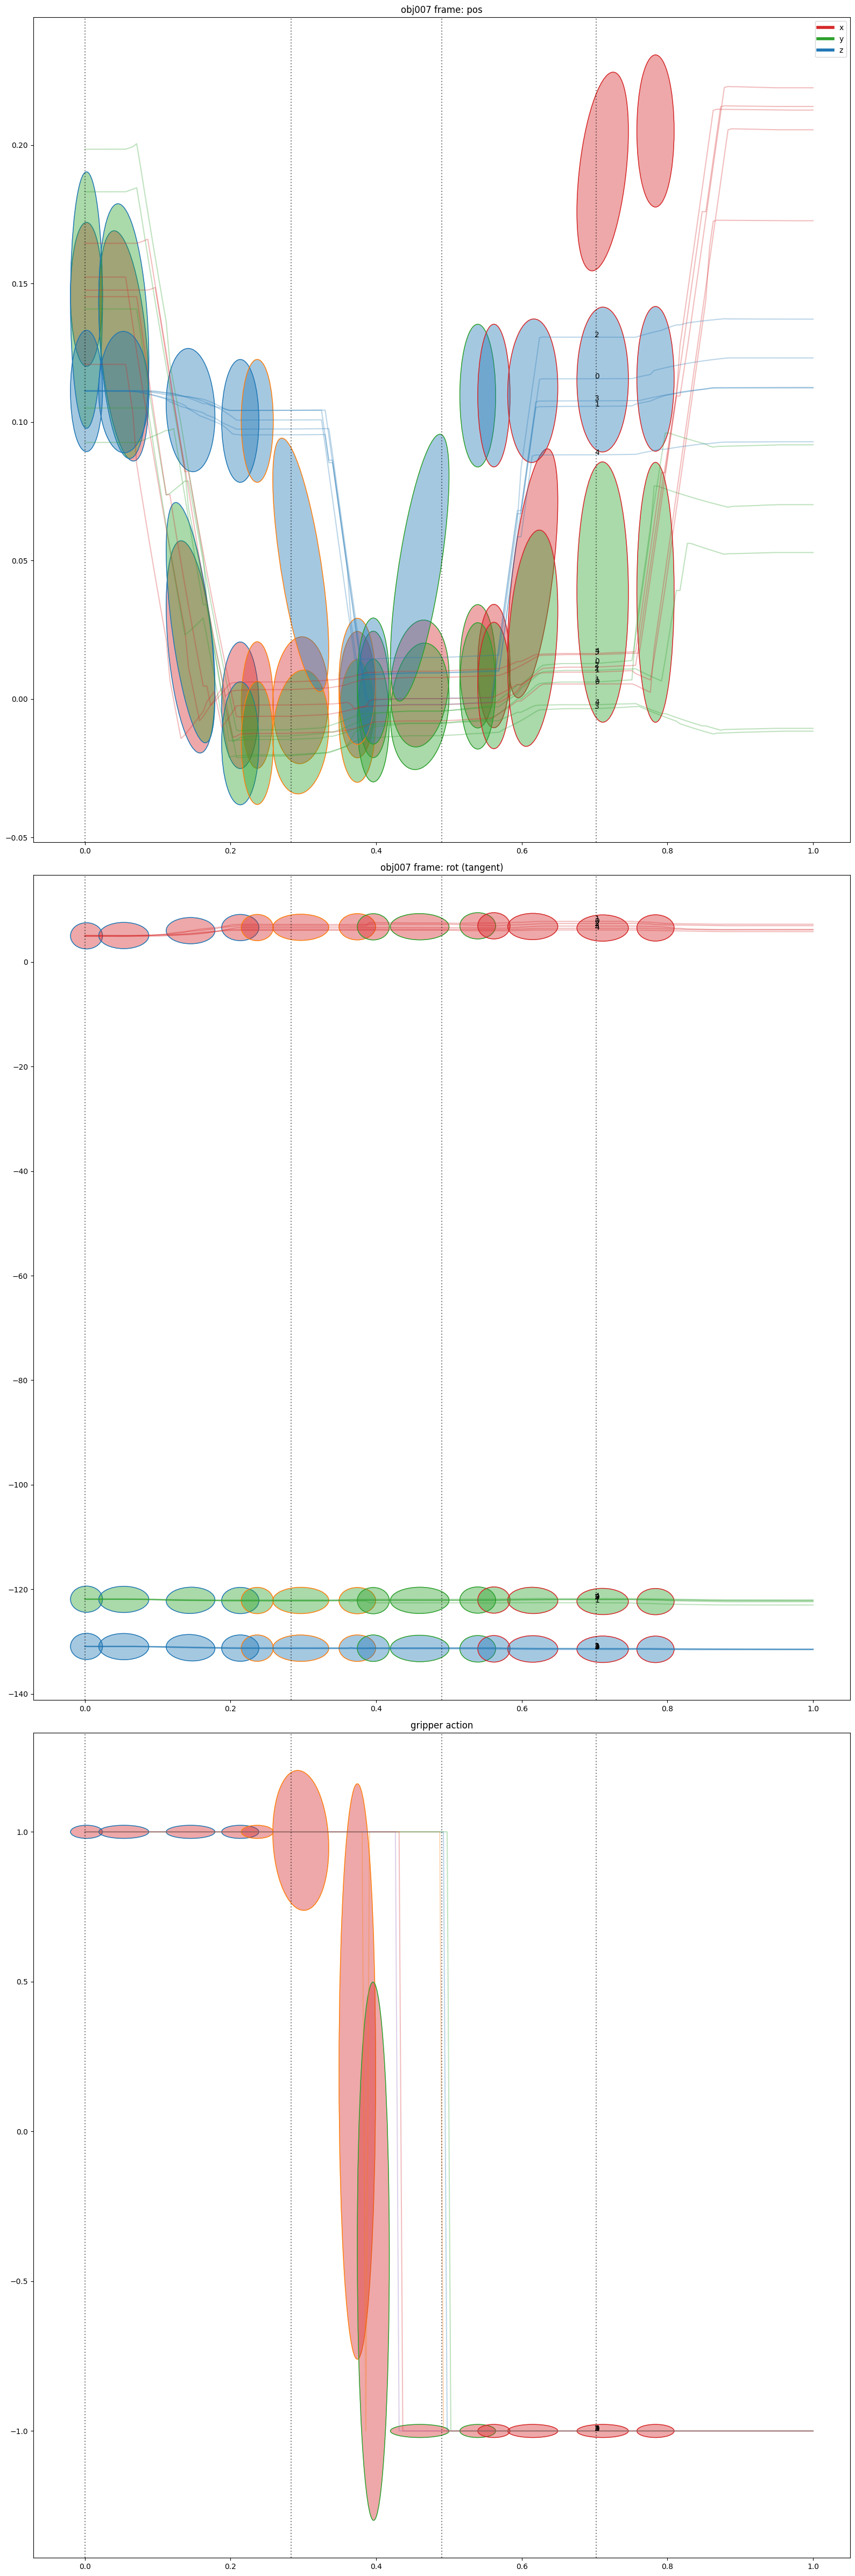

In [79]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [80]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-05 22:31:24.747 | INFO     |  Fitting AutoTPGMM


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [4.67e-086, 3.96e-006, 7.14e-005, ..., 1.09e-136, 2.13e-144,
          1.83e-147],
         [0.00e+000, 4.15e-165, 3.15e-079, ..., 2.24e-025, 1.49e-029,
          5.67e-033],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 9.91e-001, 9.24e-001,
          5.34e-001, 9.53e-002, 3.38e-003, 2.03e-005, 1.91e-008, 2.63e-012,
          5.02e-017, 1.25e-022, 3.86e-029, 5.28e-036, 3.36e-043, 9.84e-051,
          1.31e-058, 7.87e-067, 2.09e-075, 2.45e-084, 1.24e-093, 2.68e-103,
          2.43e-113, 9.19e-124, 1.42e-134, 8.85e-146, 2.19e-157, 2.14e-169,
          8.11e-182, 1.18e-194, 6.47e-208, 1.32e-221, 1.76e-234, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1

2025-08-05 22:31:41.221 | INFO     |  Did not specify time_based, deciding automatically.


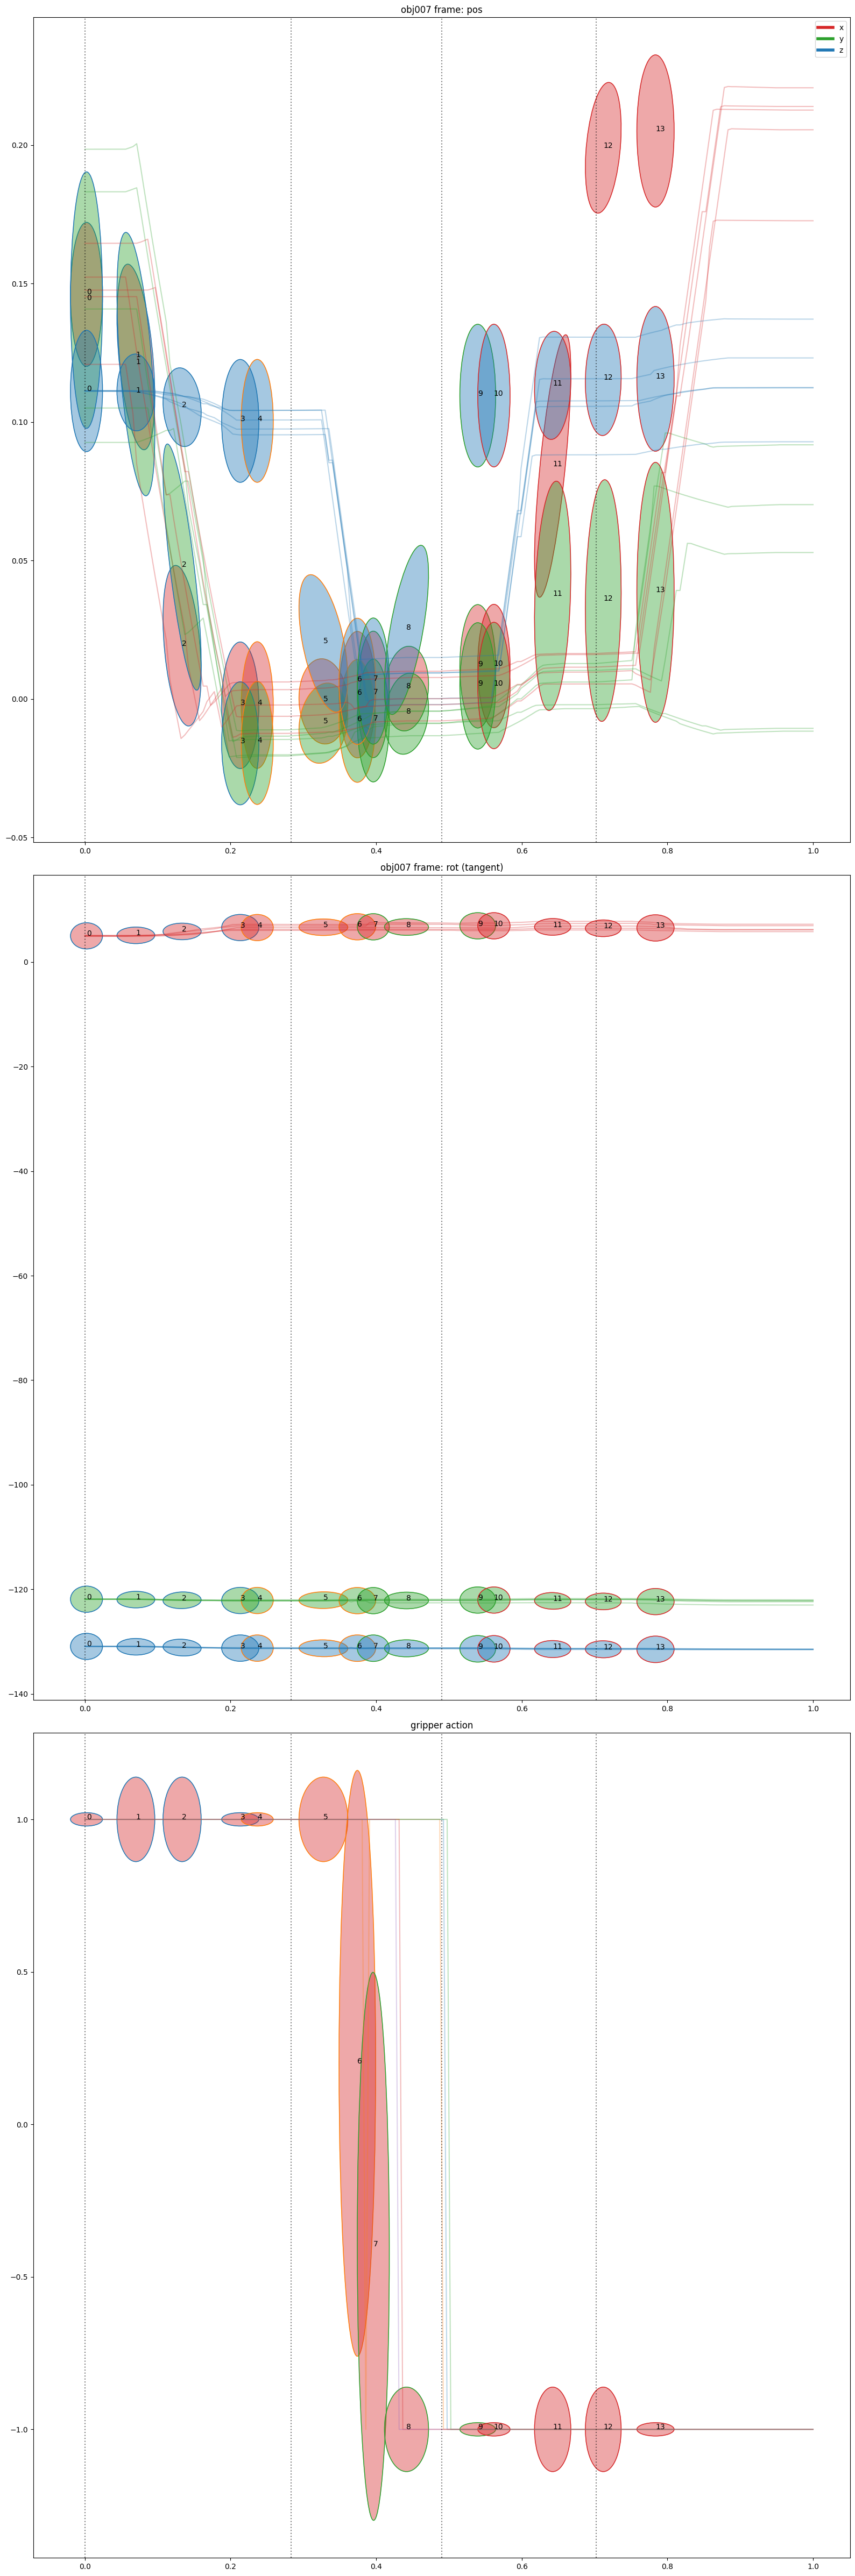

In [81]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

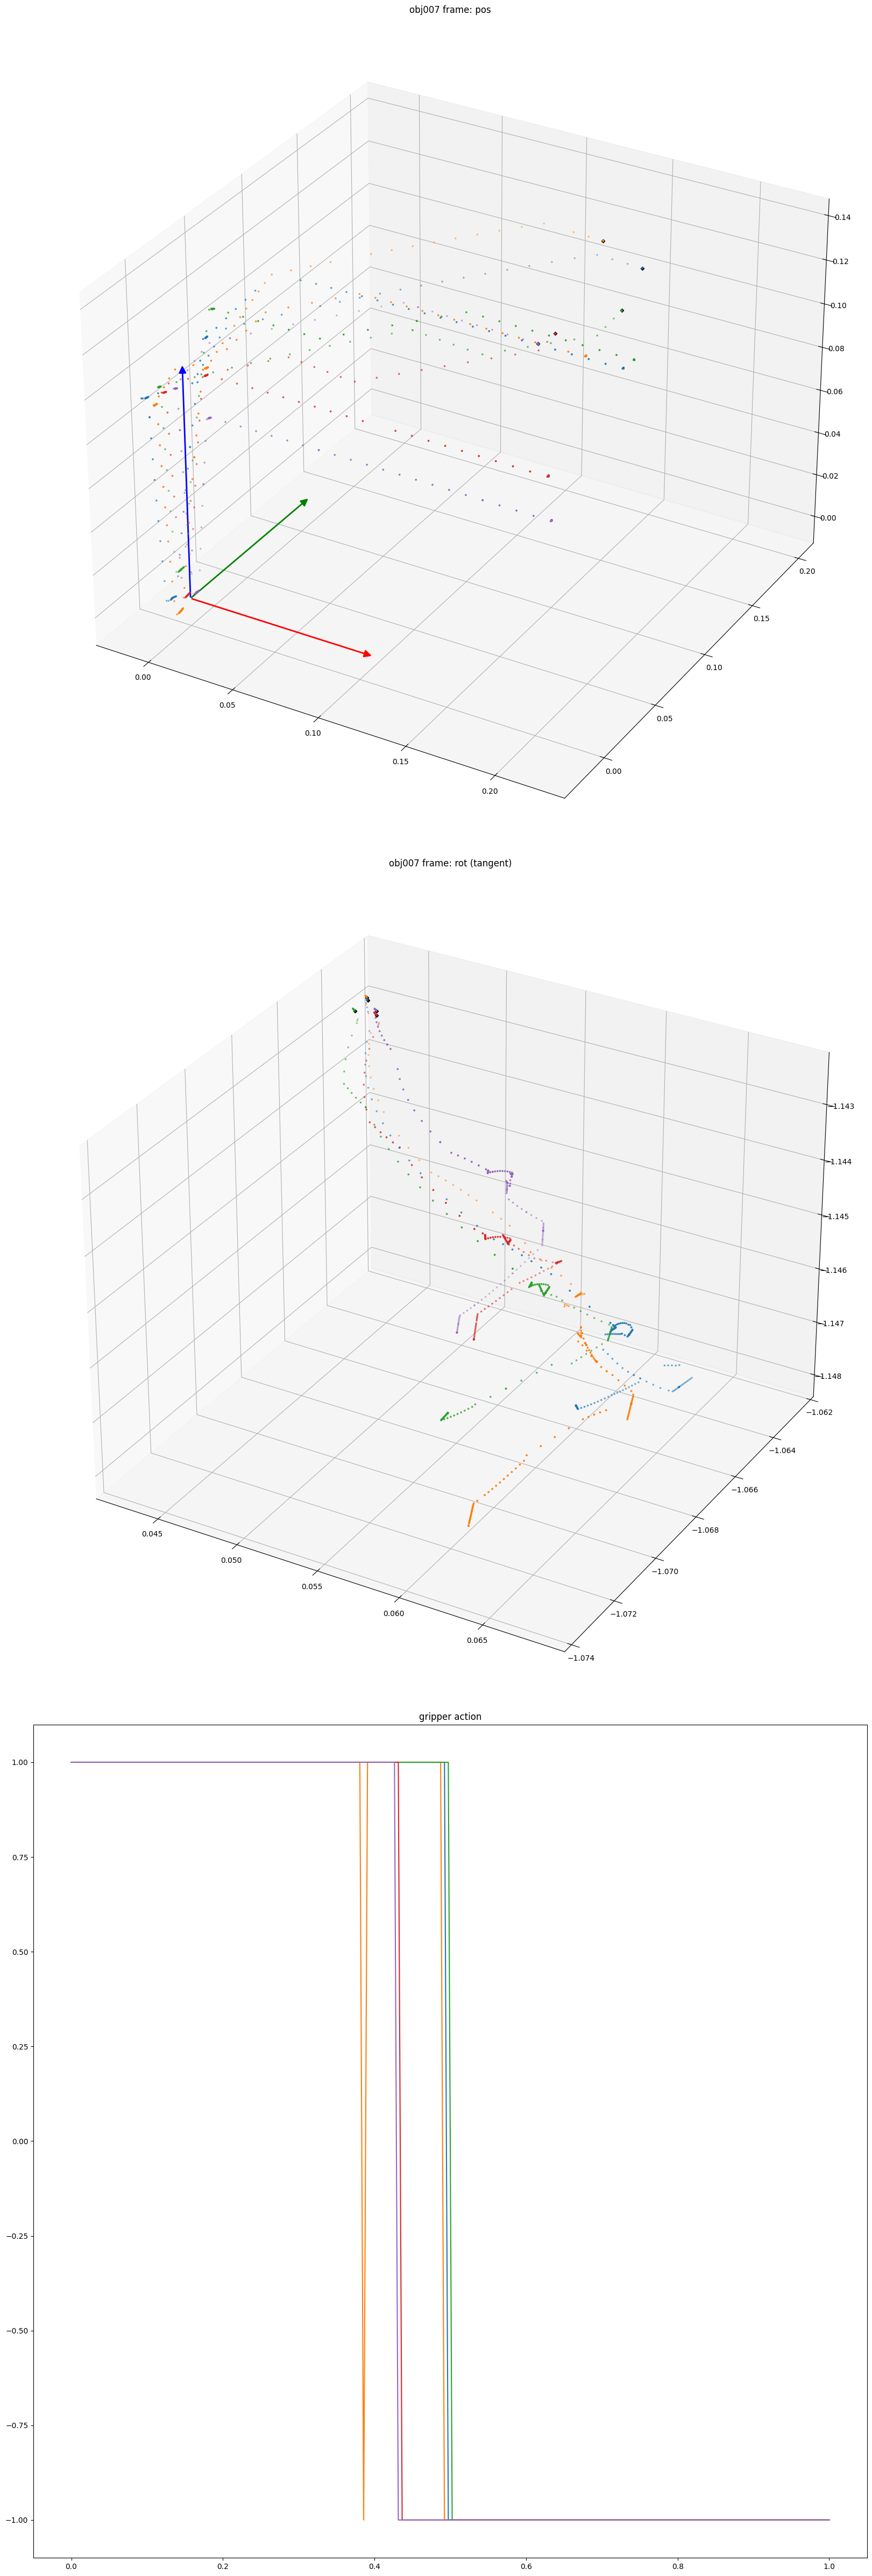

In [82]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

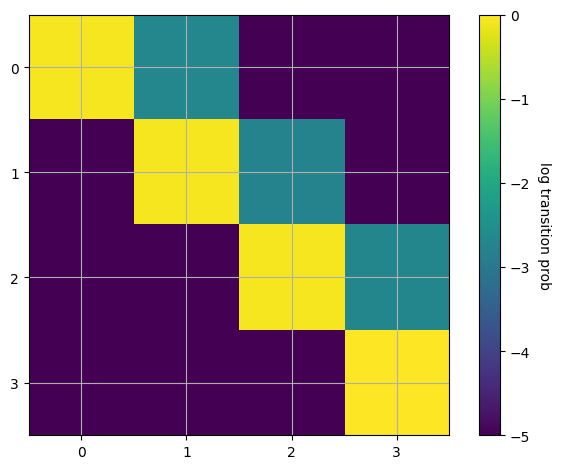

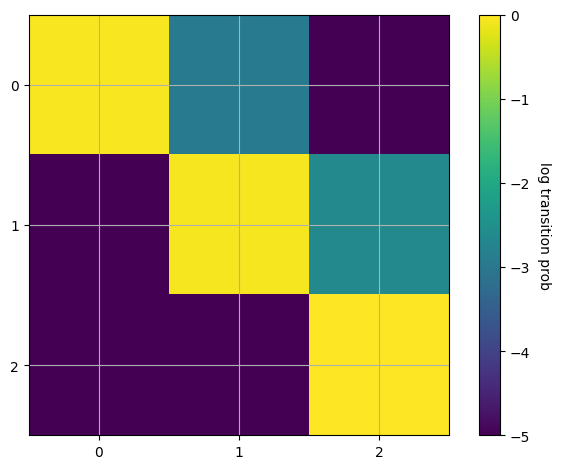

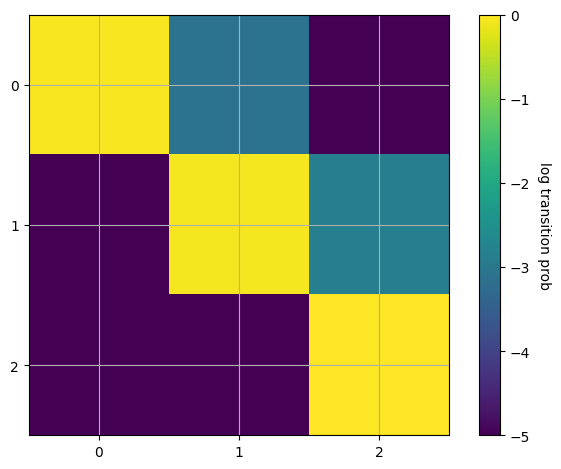

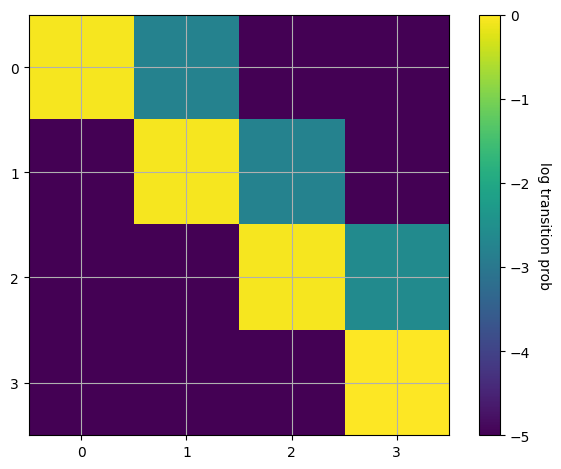

In [83]:
atpgmm.plot_hmm_transition_matrix()

In [84]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

In [85]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-05 22:31:47.404 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]), array([[1.]]))
2025-08-05 22:31:47.404 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:31:47.480 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:31:47.553 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:31:47.623 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

GMR:   0%|          | 0/5 [00:00<?, ?it/s]

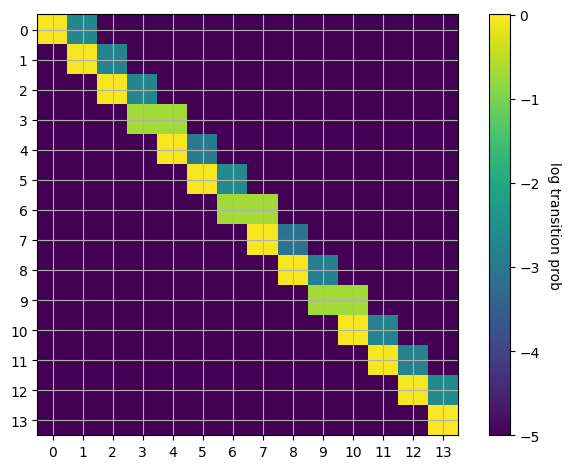

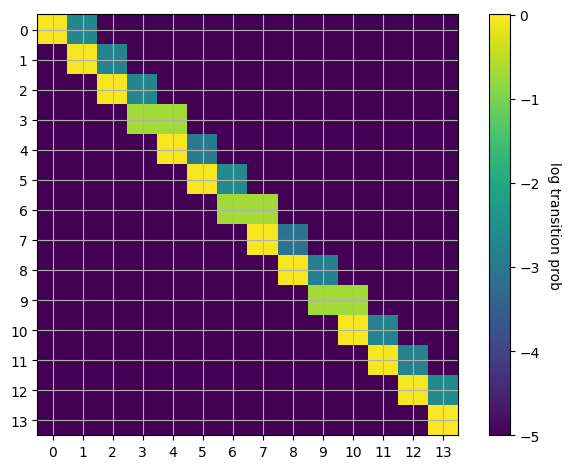

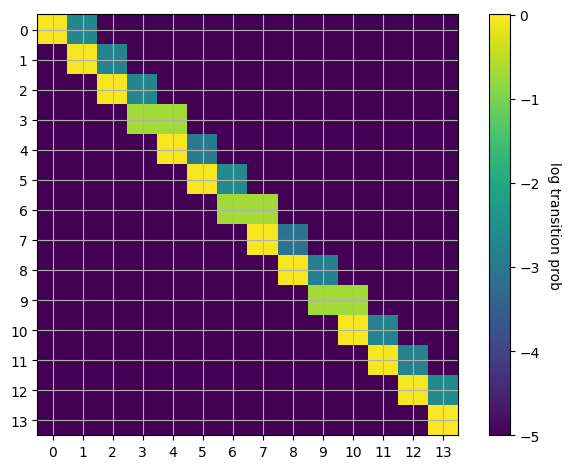

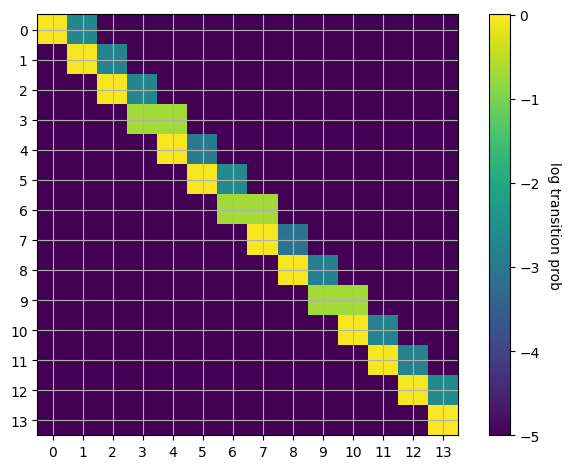

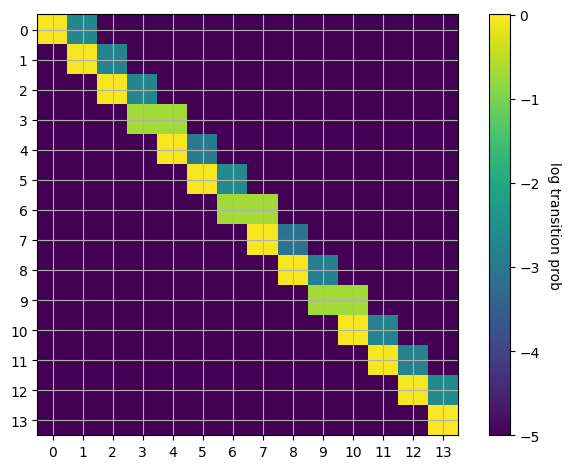

In [86]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-05 22:32:05.462 | INFO     |  Taking frame origins from demos.


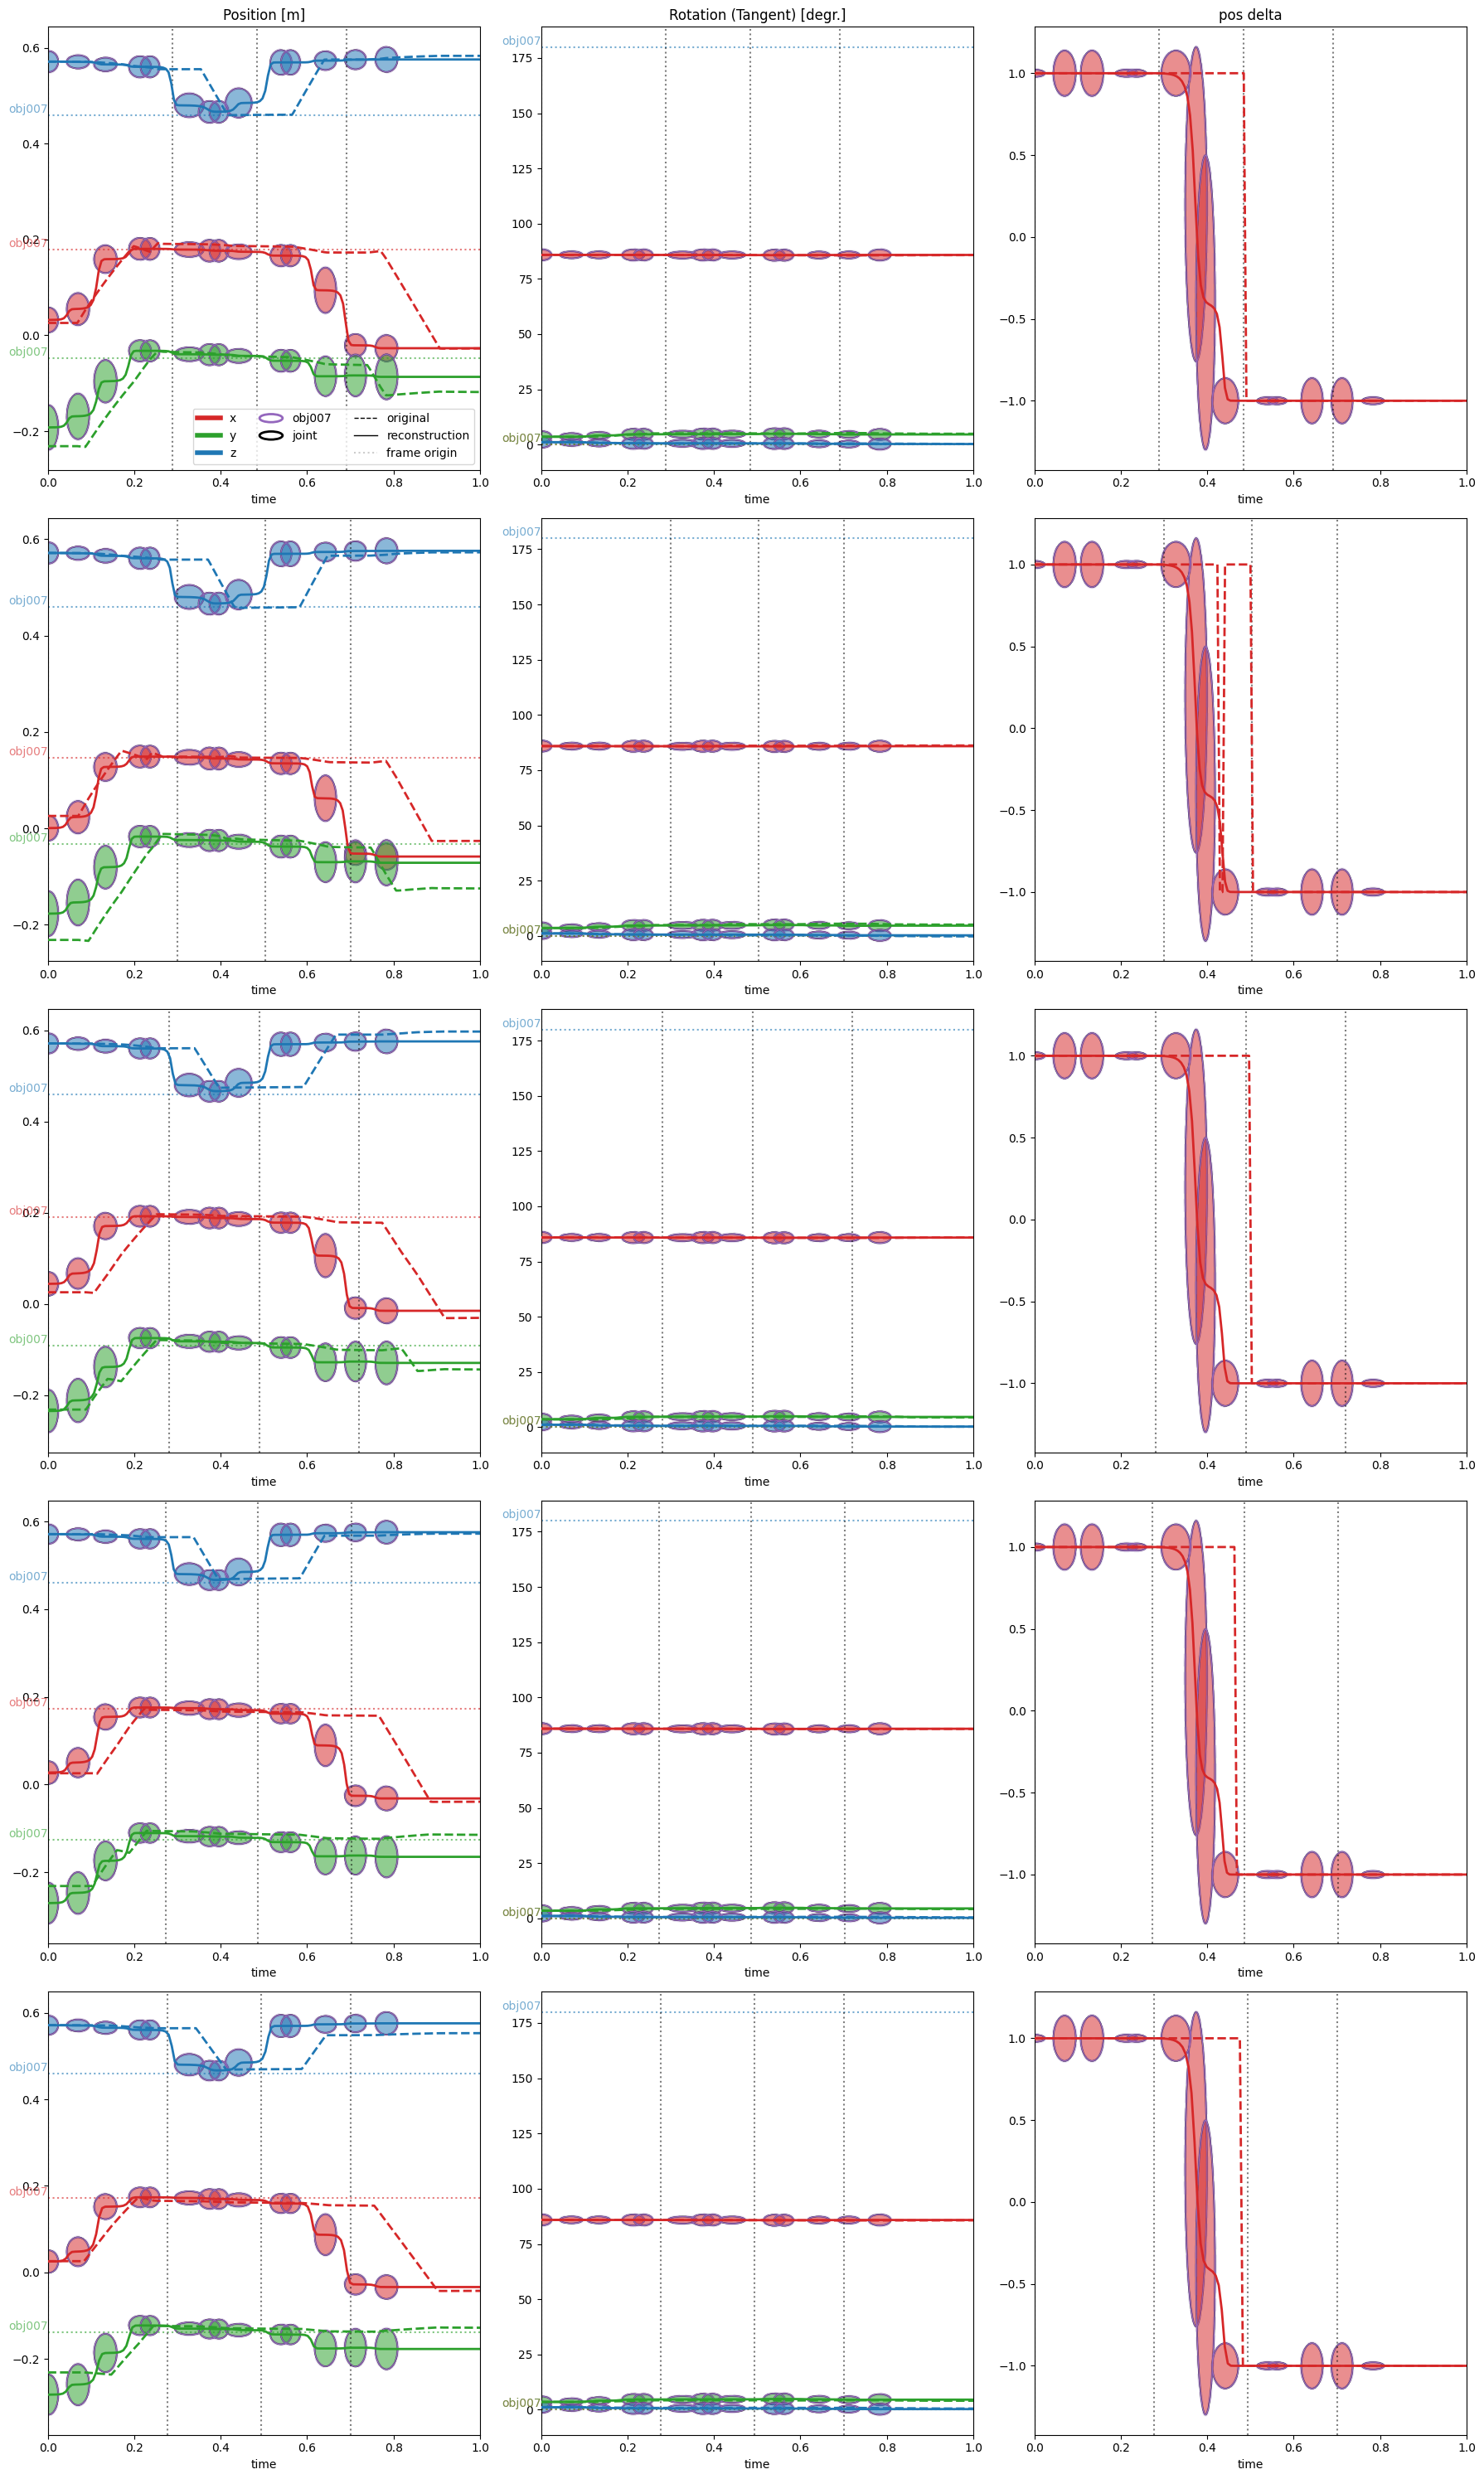

In [87]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range

: 